In [1]:
%load_ext autoreload

In [2]:
%load_ext blackcellmagic

In [3]:
%autoreload 2

In [4]:
from prefect import Flow, Parameter, unmapped
import pandas as pd
from prefect.engine.executors import DaskExecutor
from meta_model import MetaModel

In [5]:
input_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")

In [ ]:
from ml_flow import *

with Flow("data_cleaning") as flow:
    input_data = Parameter("input_data")
    problem, target, features = (
        Parameter("problem"),
        Parameter("target"),
        Parameter("features"),
    )
    tinydb = recreate_tinydb()
    nan_features = extract_nan_features(input_data)
    problematic_features = extract_problematic_features(input_data)
    undefined_features = extract_undefined_features(
        input_data, features, target, nan_features, problematic_features
    )
    input_data_with_missing = fit_transform_missing_indicator(
        input_data, undefined_features
    )

    train_valid_split = extract_train_valid_split(
        input_data=input_data_with_missing, problem=problem, target=target
    )
    train_data = extract_train_data(train_valid_split)
    valid_data = extract_valid_data(train_valid_split)
    numeric_features = extract_numeric_features(input_data, undefined_features)
    categorical_features = extract_categorical_features(input_data, undefined_features)

    # numeric columns work
    numeric_imputer = fit_numeric_imputer(train_data, numeric_features)
    imputed_train_numeric_df = impute_numeric_df(
        numeric_imputer, train_data, numeric_features
    )
    imputed_valid_numeric_df = impute_numeric_df(
        numeric_imputer, valid_data, numeric_features
    )

    yeo_johnson_transformer = fit_yeo_johnson_transformer(imputed_train_numeric_df)
    yeo_johnson_train_transformed = transform_yeo_johnson_transformer(
        imputed_train_numeric_df, yeo_johnson_transformer
    )
    yeo_johnson_valid_transformed = transform_yeo_johnson_transformer(
        imputed_valid_numeric_df, yeo_johnson_transformer
    )

    # categorical columns work
    categorical_imputer = fit_categorical_imputer(train_data, categorical_features)
    imputed_train_categorical_df = transform_categorical_data(
        train_data, categorical_features, categorical_imputer
    )
    imputed_valid_categorical_df = transform_categorical_data(
        valid_data, categorical_features, categorical_imputer
    )

    target_transformer = fit_target_transformer(problem, target, train_data)
    transformed_train_target = transform_target(
        problem, target, train_data, target_transformer
    )
    transformed_valid_target = transform_target(
        problem, target, valid_data, target_transformer
    )

    target_encoder_transformer = fit_target_encoder(
        imputed_train_categorical_df, transformed_train_target
    )
    target_encoded_train_df = target_encoder_transform(
        target_encoder_transformer, imputed_train_categorical_df
    )
    target_encoded_valid_df = target_encoder_transform(
        target_encoder_transformer, imputed_valid_categorical_df
    )

    # merge_data
    transformed_train_df = merge_transformed_data(
        target_encoded_train_df, yeo_johnson_train_transformed,
    )
    transformed_valid_df = merge_transformed_data(
        target_encoded_valid_df, yeo_johnson_valid_transformed,
    )

    # outlierness
    hbos_transformer = fit_hbos_transformer(transformed_train_df)
    hbos_transform_train_data = hbos_transform(transformed_train_df, hbos_transformer)
    hbos_transform_valid_data = hbos_transform(transformed_valid_df, hbos_transformer)

    # merge outlierness
    transformed_train_df = merge_hbos_df(
        transformed_train_df, hbos_transform_train_data
    )
    transformed_valid_df = merge_hbos_df(
        transformed_valid_df, hbos_transform_valid_data
    )
    save_data(transformed_train_df, "transformed_train.df",)
    save_data(transformed_valid_df, "transformed_valid.df",)
    
    #dimensionality reduction
    svd = fit_svd(transformed_train_df)
    svd_train = svd_transform(svd, transformed_train_df, "transformed_train_df",tinydb)
    svd_valid = svd_transform(svd, transformed_valid_df, "transformed_valid_df",tinydb)
    

    # models
    meta = MetaModel(problem="regression")
    meta.default_models()
    models = meta.models
    import pdb; pdb.set_trace()
    fit_models = fit_model.map(
        model=models,
        train_data=unmapped(transformed_train_df),
        target=unmapped(transformed_train_target),
        problem=unmapped(problem),
    )
    predict_models = predict_model.map(
        model=fit_models, valid_data=unmapped(transformed_valid_df),
    )

> <ipython-input-91-b3f195a10ace>(106)<module>()
-> fit_models = fit_model.map(
(Pdb) n
> <ipython-input-91-b3f195a10ace>(107)<module>()
-> model=models,
(Pdb) n
> <ipython-input-91-b3f195a10ace>(108)<module>()
-> train_data=unmapped(transformed_train_df),
(Pdb) s
--Call--
> /Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/prefect/utilities/tasks.py(233)__init__()
-> def __init__(self, task: "prefect.Task"):
(Pdb) s
> /Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/prefect/utilities/tasks.py(234)__init__()
-> self.task = as_task(task)
(Pdb) s
--Call--
> /Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/prefect/utilities/tasks.py(48)as_task()
-> def as_task(x: Any, flow: Optional["Flow"] = None) -> "prefect.Task":
(Pdb) s
> /Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/prefect/utilities/tasks.py(60)as_task()
-> from prefect.tasks.core.constants import Constant
(Pdb) s
--Call--
> <frozen im

In [92]:
executor = DaskExecutor()
flow_state = flow.run(
    input_data= input_df, 
    problem="regression", 
    target = "SalePrice", 
    features = "infer",
    executor=executor
)

[2020-03-12 04:48:09,840] INFO - prefect.FlowRunner | Beginning Flow run for 'data_cleaning'
[2020-03-12 04:48:09,845] INFO - prefect.FlowRunner | Starting flow run.
[2020-03-12 04:48:10,027] INFO - prefect.TaskRunner | Task 'target': Starting task run...
[2020-03-12 04:48:10,089] INFO - prefect.TaskRunner | Task 'problem': Starting task run...
[2020-03-12 04:48:10,126] INFO - prefect.TaskRunner | Task 'target': finished task run for task with final state: 'Success'
[2020-03-12 04:48:10,163] INFO - prefect.TaskRunner | Task 'problem': finished task run for task with final state: 'Success'
[2020-03-12 04:48:10,198] INFO - prefect.TaskRunner | Task 'features': Starting task run...
[2020-03-12 04:48:10,208] INFO - prefect.TaskRunner | Task 'input_data': Starting task run...
[2020-03-12 04:48:10,218] INFO - prefect.TaskRunner | Task 'recreate_tinydb': Starting task run...
[2020-03-12 04:48:10,392] INFO - prefect.TaskRunner | Task 'features': finished task run for task with final state: 'Su

[2020-03-12 04:48:16,221] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': Starting task run...
[2020-03-12 04:48:16,233] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': finished task run for task with final state: 'Success'
[2020-03-12 04:48:16,264] INFO - prefect.TaskRunner | Task 'merge_transformed_data': Starting task run...
[2020-03-12 04:48:16,264] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': finished task run for task with final state: 'Success'
[2020-03-12 04:48:16,274] INFO - prefect.TaskRunner | Task 'merge_transformed_data': finished task run for task with final state: 'Success'
[2020-03-12 04:48:16,296] INFO - prefect.TaskRunner | Task 'merge_transformed_data': Starting task run...
[2020-03-12 04:48:16,306] INFO - prefect.TaskRunner | Task 'merge_transformed_data': finished task run for task with final state: 'Success'
[2020-03-12 04:48:16,326] INFO - prefect.TaskRunner | Task 'fit_hbos_transformer': Starti

/Users/crawfordcollins/personal/crawto/crawto/meta_model.py:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.model.fit(X, y)
/Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2020-03-12 04:48:18,545] INFO - prefect.TaskRunner | Task 'fit_model[5]': finished task run for task with final state: 'Success'
[2020-03-12 04:48:18,880] INFO - prefect.TaskRunner | Task 'fit_model[6]': finished task run for task with final state: 'Success'
[2020-03-12 04:48:18,897] INFO - prefect.TaskRunner | Task 'fit_model': finished task run for task with final state: 'Mapped'
[2020-03-12 04:48:18,917] INFO - prefect.TaskRunner | Task 'predict_model': Starting task run...
[2020-03-12 04:48:20,018] INFO - prefect.TaskRunner | Task 'predict_model[5]': Starting task run...
[2020-03-12 04:48:20,021] INFO - prefect.TaskRunner | Task 'predict_model[2]': Starting task run...
[2020-03-12 04:48:20,035] INFO - prefect.TaskRunner | Task 'predict_model[4]': Starting task run...
[2020-03-12 04:48:20,039] INFO - prefect.TaskRunner | Task 'predict_model[3]': Starting task run...
[2020-03-12 04:48:20,044] INFO - prefect.TaskRunner | Task 'predict_model[0]': Starting task run...
[2020-03-12 04:48

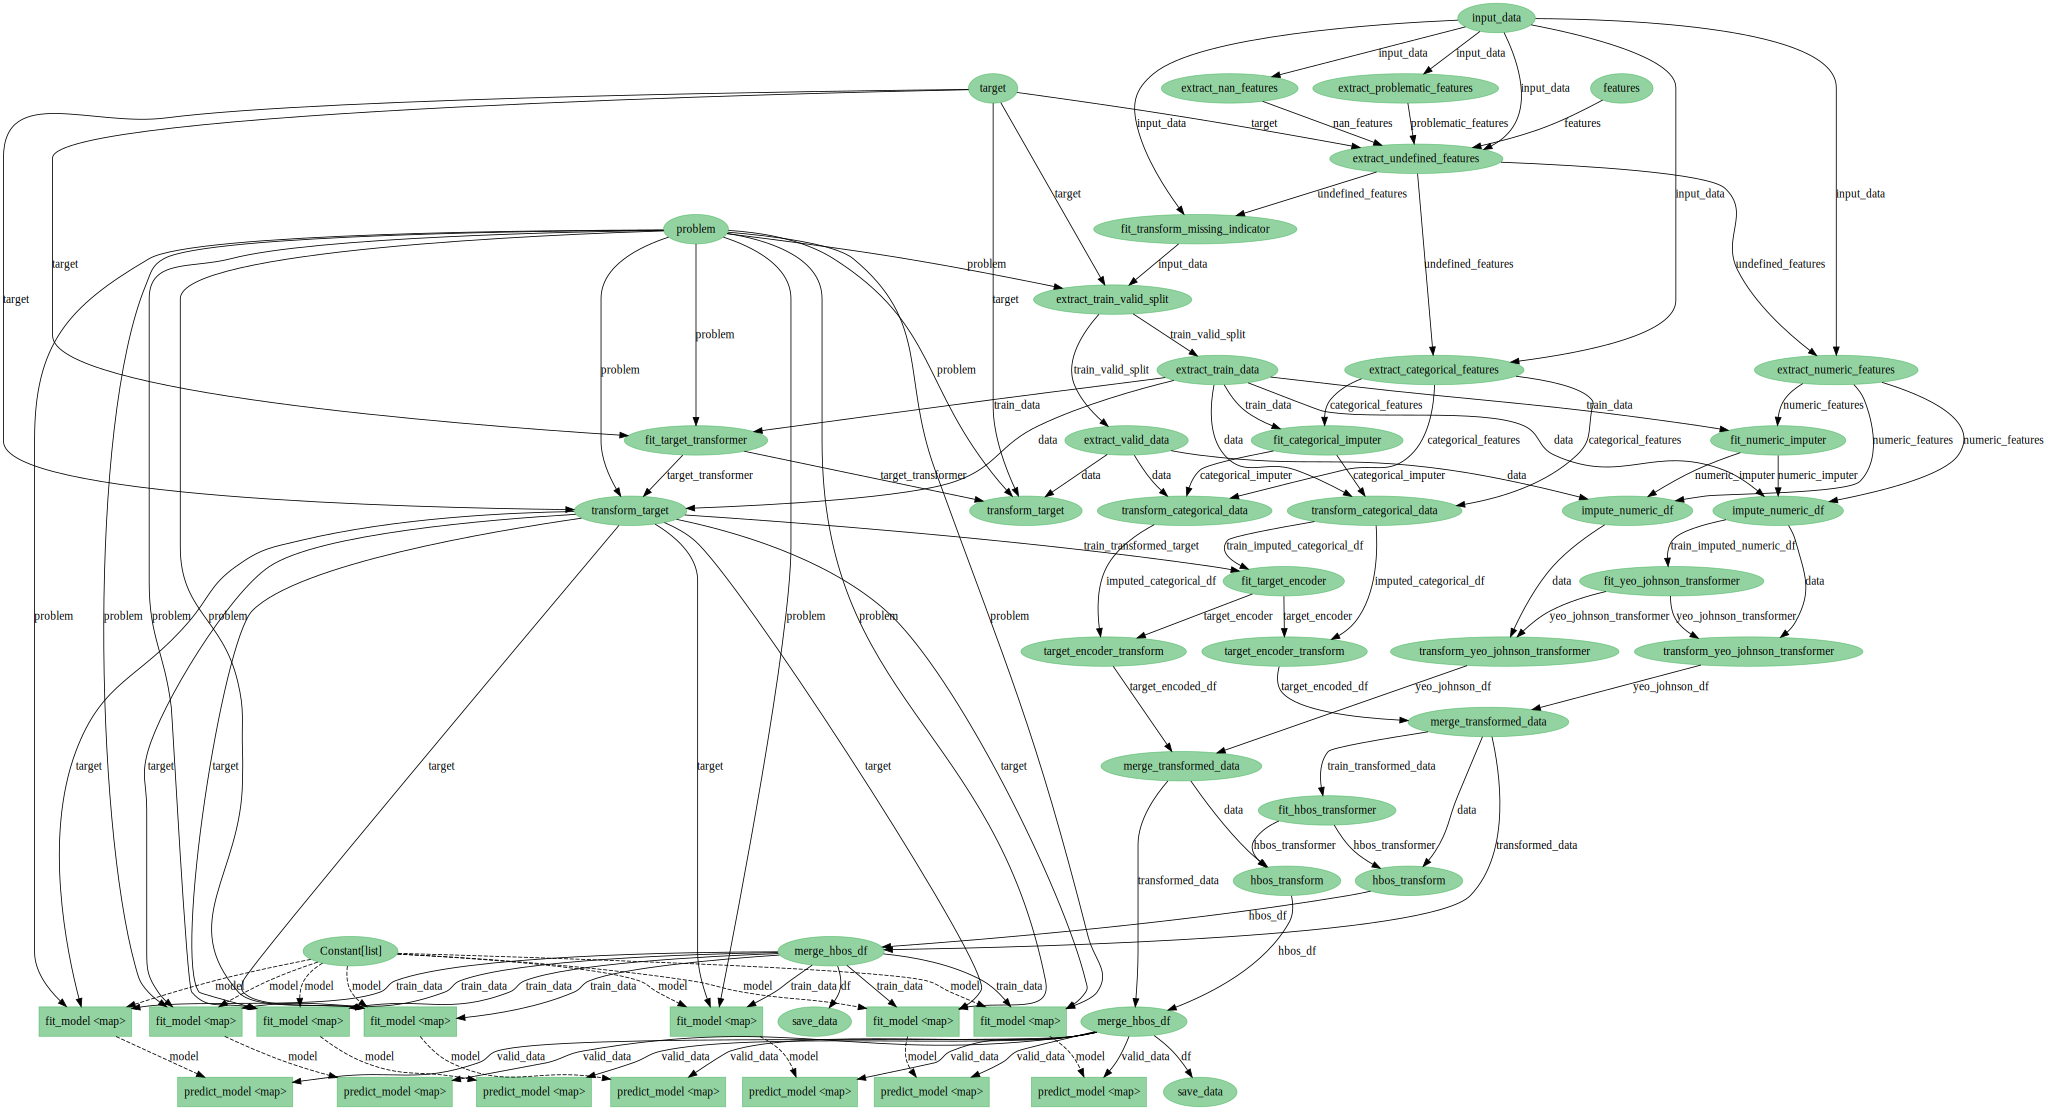

In [38]:
flow.visualize(flow_state=flow_state)

In [86]:
from tinydb import TinyDB, Query
db = TinyDB("db.json")
db.all()

[]

In [ ]:
q = Query()
r = db.search(q.chunk == "svdname")

In [75]:
dir(q.chunk

['__and__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_generate_test',
 '_path',
 '_prepare_test',
 '_test',
 'all',
 'any',
 'exists',
 'hashval',
 'matches',
 'one_of',
 'search',
 'test']

In [119]:
flow._sorted_tasks()[38]

typing.Any

In [110]:
dir(flow._sorted_tasks()[38])

['__add__',
 '__and__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__mifflin__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 'auto_generated',
 'bind',
 'cache_for',
 'cache_key',
 'cache_validator',
 'checkpoint',
 'copy',
 'inputs',
 'is_equal',
 'is_not_equal',
 'log_stdout',
 'logger',
 'map',
 'max_retries',
 'name',
 'not_',
 'or_',
 'outputs',
 'result_handler',
 'retry_delay',
 'run',
 'serialize',
 'set_dependencies',
 'set_